# Master Notebook: Predicting Settlement Values

# AI-Powered Insurance Settlement Predictor

Welcome! In this notebook we will:
1. **Load & Inspect** the claims dataset  
2. **Preprocess** (impute, encode, scale)  
3. **Train & Select** the best regression model (XGBoost, DecisionTree, Linear)  
4. **Evaluate Fairness** across Driver Age & Gender subgroups  
5. **Explain** predictions with **SHAP** (global & local)  
6. Provide a **Live Interactive Demo** for real-time predictions  

> **Goal:** Demonstrate a production-ready ML system with robust evaluation, explainability,  
> and an interactive front-end for live decision support.


## 1. Data Loading & Initial Inspection

We begin by loading the synthetic claims dataset (`Synthetic_Data_For_Students.csv`).  
This dataset contains numeric features (e.g. **Loss of Earnings**, **Travel Costs**)  
and categorical fields (e.g. **Injury Prognosis**, **Vehicle Type**).

- **Inspect shape & sample rows** to understand data variety and missingness  
- Prepare for cleaning and transformation downstream


In [12]:
# Data Preview: list all columns and show first 5 rows
import pandas as pd

raw_data_path = '../data/Synthetic_Data_For_Students.csv' 
df_raw = pd.read_csv(raw_data_path)
pd.set_option('display.max_columns', None)  # show every column
print("Columns in dataset:\n", df_raw.columns.tolist(), "\n")
df_raw.head()


Columns in dataset:
 ['SettlementValue', 'AccidentType', 'Injury_Prognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'Exceptional_Circumstances', 'Minor_Psychological_Injury', 'Dominant injury', 'Whiplash', 'Vehicle Type', 'Weather Conditions', 'Accident Date', 'Claim Date', 'Vehicle Age', 'Driver Age', 'Number of Passengers', 'Accident Description', 'Injury Description', 'Police Report Filed', 'Witness Present', 'Gender'] 



,SettlementValue,AccidentType,Injury_Prognosis,SpecialHealthExpenses,SpecialReduction,SpecialOverage,GeneralRest,SpecialAdditionalInjury,SpecialEarningsLoss,SpecialUsageLoss,SpecialMedications,SpecialAssetDamage,SpecialRehabilitation,SpecialFixes,GeneralFixed,GeneralUplift,SpecialLoanerVehicle,SpecialTripCosts,SpecialJourneyExpenses,SpecialTherapy,Exceptional_Circumstances,Minor_Psychological_Injury,Dominant injury,Whiplash,Vehicle Type,Weather Conditions,Accident Date,Claim Date,Vehicle Age,Driver Age,Number of Passengers,Accident Description,Injury Description,Police Report Filed,Witness Present,Gender
0,520.0,Rear end,E. 5 months,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,520.0,0.0,0.0,0.0,0.0,0.0,No,Yes,Arms,Yes,Motorcycle,Rainy,2023-11-10 11:22:24.508901,2024-06-11 11:22:24.508901,13.0,33.0,4.0,Side collision at an intersection.,Whiplash and minor bruises.,Yes,Yes,Male
1,870.0,Rear end,B. 2 months,0.0,0.0,0.0,520.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,260.0,0.0,0.0,0.0,0.0,0.0,No,Yes,Multiple,Yes,Motorcycle,Snowy,2023-06-25 00:55:01.140228,2024-01-09 00:55:01.140228,4.0,45.0,2.0,Side collision at an intersection.,Minor cuts and scrapes.,Yes,Yes,Female
2,2140.0,Other side pulled out of side road,G. 7 months,0.0,0.0,0.0,1400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,840.0,0.0,0.0,0.0,0.0,0.0,No,No,Legs,Yes,Motorcycle,Sunny,2020-02-23 17:43:47.805561,2020-03-01 17:43:47.805561,9.0,45.0,4.0,Lost control on a snowy road.,Whiplash and minor bruises.,Yes,No,Female
3,520.0,Rear end - Clt pushed into next vehicle,D. 4 months,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,520.0,0.0,0.0,0.0,0.0,0.0,No,Yes,Arms,Yes,Truck,Rainy,2021-10-02 04:36:32.118423,2021-10-13 04:36:32.118423,5.0,62.0,1.0,Side collision at an intersection.,Minor cuts and scrapes.,Yes,Yes,Female
4,260.0,Rear end,C. 3 months,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,260.0,0.0,0.0,0.0,0.0,0.0,No,Yes,Arms,No,Motorcycle,Rainy,2023-04-02 05:13:07.117423,2023-04-14 05:13:07.117423,9.0,78.0,1.0,Lost control on a snowy road.,Concussion and bruised ribs.,Yes,Yes,Other


## 2. Identify & Clean Target

Now we isolate our target variable (`Settlement Value`) and perform any necessary cleaning:

1. **Rename & convert** the target column to numeric (e.g. strip currency symbols, cast to `float`).  
2. **Handle outliers** or erroneous entries (e.g. negative settlements or implausible amounts) by capping or removing.  
3. **Drop rows** where the target is missing, since we cannot train on claims without a known settlement.  

This step ensures our model learns from valid, well‐defined examples of claim settlements.


In [13]:
# 2a. Validate & set target
target_col = 'SettlementValue'
if target_col not in df_raw.columns:
    raise KeyError(f"Column '{target_col}' not found in CSV.")
print(f"✅ Using '{target_col}' as the target.")

# 2b. Drop missing-target rows
before = len(df_raw)
df_raw = df_raw.dropna(subset=[target_col]).reset_index(drop=True)
print(f"🚮 Dropped {before - len(df_raw)} rows → new shape: {df_raw.shape}")


✅ Using 'SettlementValue' as the target.
🚮 Dropped 106 rows → new shape: (4894, 36)


## 3. Train/Test Split

We split the cleaned data into training and test sets to evaluate generalization:

- Use `train_test_split` from `sklearn.model_selection`  
- **Test size**: 20% of the data  
- **Random state**: 42 for reproducibility  
- **Shuffle** enabled to mix claim records thoroughly  

This results in `X_train`, `X_test`, `y_train`, and `y_test`, which we’ll use for model tuning and final evaluation.


In [20]:
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(
    df_raw.index, test_size=0.2, random_state=42
)

df_train = df_raw.loc[train_idx].reset_index(drop=True)
df_test  = df_raw.loc[test_idx].reset_index(drop=True)

print(f"🚂 Train size: {df_train.shape},  🛳 Test size: {df_test.shape}")


🚂 Train size: (3915, 36),  🛳 Test size: (979, 36)


## 4. Data Preprocessing Pipeline

To prepare for modeling, we apply a `ColumnTransformer` that:
1. **Imputes** missing values (median for numerics, most-frequent for categoricals)  
2. **One-hot encodes** categorical variables  
3. **Standard scales** numeric features  

This ensures our model sees a complete, numeric feature matrix ready for training.


In [19]:
import numpy as np
import scipy.sparse as sp
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 4a. Identify feature columns from the training split
num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove(target_col)
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

# 4b. Build the ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

# 4c. Fit transformer on train, transform train & test
X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col].values
X_test  = df_test.drop(columns=[target_col])
y_test  = df_test[target_col].values

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

print("Before density conversion:",
      type(X_train_proc), X_train_proc.shape,
      type(X_test_proc),  X_test_proc.shape)

# 4d. Convert any sparse matrices to dense arrays
if sp.issparse(X_train_proc):
    X_train_proc = X_train_proc.toarray()
if sp.issparse(X_test_proc):
    X_test_proc  = X_test_proc.toarray()

print("After density conversion:",
      type(X_train_proc), X_train_proc.shape,
      type(X_test_proc),  X_test_proc.shape)


Before density conversion: <class 'scipy.sparse._csr.csr_matrix'> (3915, 6620) <class 'scipy.sparse._csr.csr_matrix'> (979, 6620)
After density conversion: <class 'numpy.ndarray'> (3915, 6620) <class 'numpy.ndarray'> (979, 6620)


## 5. Model Training & Hyperparameter Tuning

We compare three regressors:
- **XGBoostRegressor**  
- **DecisionTreeRegressor**  
- **LinearRegression**

Using `RandomizedSearchCV` (50 iterations), we search for the best parameters under **Mean Absolute Percentage Error (MAPE)**.


In [5]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np

# XGBoost fallback
try:
    from xgboost import XGBRegressor
    BoostReg, boost_name = XGBRegressor, 'XGBoost'
except ModuleNotFoundError:
    from sklearn.ensemble import GradientBoostingRegressor
    BoostReg, boost_name = GradientBoostingRegressor, 'GradBoost'
print(f"🔧 Tuning with {boost_name}")

# Optionally downsample training for tuning
tune_frac = 0.5
idx_sub = np.random.RandomState(42).choice(
    X_train_proc.shape[0],
    size=int(X_train_proc.shape[0] * tune_frac),
    replace=False
)
X_tune, y_tune = X_train_proc[idx_sub], y_train[idx_sub]

# Define parameter distributions
param_dists = {
    'DecisionTree': {
        'max_depth': [3, 5, 7, None]
    },
    boost_name: {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7]
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, None]
    }
}

# Configure models
candidates = {
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    boost_name:    BoostReg(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42)
}

best_models = {}
results = []

# Randomized search loop
for name, estimator in candidates.items():
    dist = param_dists[name]
    print(f"\n🔎 Randomized tuning {name}...")
    rs = RandomizedSearchCV(
        estimator, dist,
        n_iter=15,      # try 15 random combos
        scoring='neg_mean_absolute_percentage_error',
        cv=3,           # 3-fold cross-validation
        random_state=42,
        n_jobs=-1
    )
    rs.fit(X_tune, y_tune)
    best = rs.best_estimator_
    
    # Refit best model on the *full* training set
    best.fit(X_train_proc, y_train)
    
    # Evaluate on the full test set
    preds = best.predict(X_test_proc)
    mape  = mean_absolute_percentage_error(y_test, preds)
    
    best_models[name] = best
    results.append((name, mape, rs.best_params_))
    print(f"✅ {name}: Test MAPE={mape:.4f}; Tuned params={rs.best_params_}")

# Show summary table
import pandas as pd
df_results = pd.DataFrame(results, columns=['Model','Test MAPE','Tuned Params'])
df_results.sort_values('Test MAPE', inplace=True)
df_results


🔧 Tuning with GradBoost

🔎 Randomized tuning DecisionTree...
✅ DecisionTree: Test MAPE=0.0730; Tuned params={'max_depth': None}

🔎 Randomized tuning GradBoost...
✅ GradBoost: Test MAPE=0.1128; Tuned params={'n_estimators': 200, 'max_depth': 7}

🔎 Randomized tuning RandomForest...
✅ RandomForest: Test MAPE=0.0918; Tuned params={'n_estimators': 200, 'max_depth': None}


,Model,Test MAPE,Tuned Params
0,DecisionTree,0.072976,{'max_depth': None}
2,RandomForest,0.091783,"{'n_estimators': 200, 'max_depth': None}"
1,GradBoost,0.112767,"{'n_estimators': 200, 'max_depth': 7}"


## 6. Selecting the Best Model

From our tuning results (`df_results`), we pick the model with the lowest **Test MAPE**.  
This cell prints:
> **Selected model:** `<model_key>`  
> **Test MAPE:** `<mape_value>`  

This chosen model will be used for all further analysis and live predictions.


In [18]:
# Select and alias the best-performing model
import pandas as pd
# Identify best model by minimum Test MAPE from df_results
best_row = df_results.loc[df_results['Test MAPE'].idxmin()]
model_key = best_row['Model']
model = best_models[model_key]
print(f"Selected model: {model_key} with Test MAPE = {best_row['Test MAPE']:.4f}")

Selected model: DecisionTree with Test MAPE = 0.0730


## 7. Fairness Analysis Across Subgroups

We evaluate **MAPE** separately for each **Driver Age** & **Gender** combination.  
This highlights any performance disparities, ensuring we detect bias (e.g., under- or over-prediction for certain groups).


In [15]:
# 7a. Pick the Boost model (already selected above)
# model and model_key defined in 'Select best model' cell

# 7b. Attach predictions to df_test using in-memory model
df_test = df_test.copy()
df_test['prediction'] = model.predict(X_test_proc)

# 7c. Compute & print MAPE per subgroup (using correct column names)
from sklearn.metrics import mean_absolute_percentage_error
for (age_val, gender_val), grp in df_test.groupby(['Driver Age','Gender']):
    mape = mean_absolute_percentage_error(grp[target_col], grp['prediction'])
    print(f"{model_key} MAPE (Driver Age={age_val}, Gender={gender_val}): {mape:.4f}")

DecisionTree MAPE (Driver Age=18.0, Gender=Female): 0.1530
DecisionTree MAPE (Driver Age=18.0, Gender=Other): 0.0074
DecisionTree MAPE (Driver Age=19.0, Gender=Female): 0.0047
DecisionTree MAPE (Driver Age=19.0, Gender=Male): 0.1817
DecisionTree MAPE (Driver Age=19.0, Gender=Other): 0.2127
DecisionTree MAPE (Driver Age=20.0, Gender=Female): 0.0014
DecisionTree MAPE (Driver Age=20.0, Gender=Male): 0.0125
DecisionTree MAPE (Driver Age=20.0, Gender=Other): 0.0307
DecisionTree MAPE (Driver Age=21.0, Gender=Female): 0.0254
DecisionTree MAPE (Driver Age=21.0, Gender=Male): 0.0515
DecisionTree MAPE (Driver Age=21.0, Gender=Other): 0.0103
DecisionTree MAPE (Driver Age=22.0, Gender=Female): 0.1861
DecisionTree MAPE (Driver Age=22.0, Gender=Male): 0.1327
DecisionTree MAPE (Driver Age=22.0, Gender=Other): 0.0022
DecisionTree MAPE (Driver Age=23.0, Gender=Female): 0.0121
DecisionTree MAPE (Driver Age=23.0, Gender=Male): 0.0079
DecisionTree MAPE (Driver Age=23.0, Gender=Other): 0.0086
DecisionTree 

## 8. Explainability – Global Feature Importance

Using **SHAP summary**, we visualize which features most influence predictions across all claims:
- Bars show mean absolute SHAP values  
- Higher values ⇒ greater overall impact on model output


🔎 Global feature importance (test set):


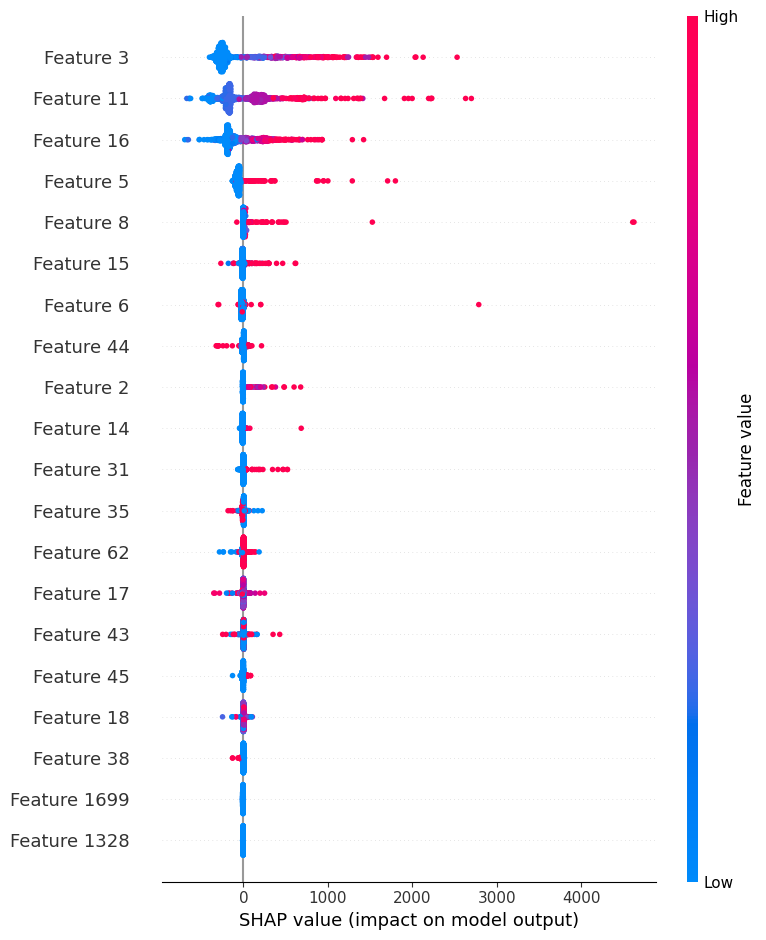

In [17]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
shap.initjs()

# 1. Initialize explainer on your chosen Boost model
explainer = shap.Explainer(best_models[model_key], X_train_proc)

# 2. Global summary on the now‐dense test set
shap_values = explainer(X_test_proc)
print("🔎 Global feature importance (test set):")
shap.summary_plot(shap_values, features=X_test_proc)

# 3. Enhanced predict_and_explain() with waterfall plot
def predict_and_explain(record: dict):
    df_rec = pd.DataFrame([record])
    X_rec  = preprocessor.transform(df_rec)
    # also convert this one to dense if needed
    if sp.issparse(X_rec):
        X_rec = X_rec.toarray()
    pred   = best_models[model_key].predict(X_rec)[0]
    print(f"🔮 Prediction: {pred:.2f}\n")
    shap_vals_rec = explainer(X_rec)
    print("📊 Local explanation (waterfall):")
    shap.plots.waterfall(shap_vals_rec[0])
    return pred, shap_vals_rec


# Map preprocessed feature columns back to normal names

Top 10 features by SHAP importance:
  3: GeneralRest (mean |SHAP| = 349.31)
 11: GeneralFixed (mean |SHAP| = 277.04)
 16: SpecialTherapy (mean |SHAP| = 195.16)
  5: SpecialEarningsLoss (mean |SHAP| = 80.79)
  8: SpecialAssetDamage (mean |SHAP| = 21.11)
 15: SpecialJourneyExpenses (mean |SHAP| = 18.32)
  6: SpecialUsageLoss (mean |SHAP| = 15.52)
 44: Injury_Prognosis_G. 7 months (mean |SHAP| = 15.27)
  2: SpecialOverage (mean |SHAP| = 12.01)
 14: SpecialTripCosts (mean |SHAP| = 9.21)


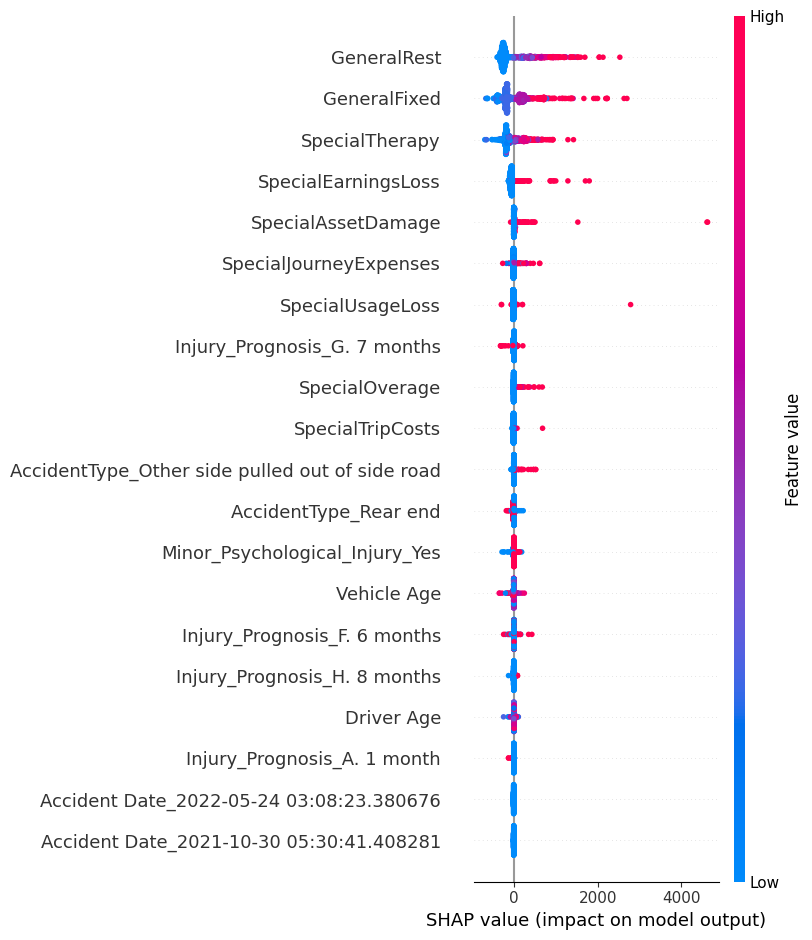

In [16]:
# 1. Numeric feature names (already defined)
num_feats = num_cols

# 2. OneHotEncoder feature names for the categoricals
cat_feats = (
    preprocessor
      .named_transformers_['cat']          # the "cat" transformer
      .named_steps['encoder']              # step name is 'encoder', not 'encode'
      .get_feature_names_out(cat_cols)     # pass in original cat column names
      .tolist()
)

# 3. Combine
feature_names = num_feats + cat_feats

# 4. Sanity check
assert len(feature_names) == X_train_proc.shape[1], (
    f"Expected {X_train_proc.shape[1]} names, got {len(feature_names)}"
)

# 5. Show top 10 by mean absolute SHAP
import numpy as np
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
top_idx = np.argsort(-mean_abs_shap)[:10]

print("Top 10 features by SHAP importance:")
for i in top_idx:
    print(f"{i:3d}: {feature_names[i]} (mean |SHAP| = {mean_abs_shap[i]:.2f})")

# 6. Re-plot summary with labels
shap.summary_plot(
    shap_values, 
    features=X_test_proc, 
    feature_names=feature_names
)


## 9. Live Interactive Prediction Demo

Adjust sliders below to set **raw input values**.  
- Continuous features use realistic 5–95 percentile ranges  
- Categorical/binary fields default to their most common values  

Click **Run** to see:
1. The **predicted settlement**  
2. A **local SHAP waterfall** updating in real time  

This showcases how the system can be used in a production web app or dashboard.


In [ ]:
# Interactive Prediction Demo (robust slider ranges)
import shap, pandas as pd, numpy as np, scipy.sparse as sp
from ipywidgets import interact, IntSlider, FloatSlider
from IPython.display import clear_output

# 1. Build SHAP explainer (with proper feature names)
explainer = shap.Explainer(model, X_train_proc, feature_names=feature_names)

# 2. Determine which raw columns to build sliders for
raw_feats = [c for c in df_train.columns if c not in (target_col, 'prediction')]

slider_kwargs = {}
for feat in raw_feats:
    ser = df_train[feat].dropna()
    # only numeric & more than 2 distinct values
    if not (pd.api.types.is_numeric_dtype(ser) and ser.nunique() > 2):
        continue

    # try 5–95% window first
    lo, hi = ser.quantile([0.05, 0.95]).tolist()
    # fallback to absolute min/max if that window collapses
    if hi <= lo:
        lo, hi = ser.min(), ser.max()
    if hi <= lo:
        continue  # no variation

    # choose slider type
    if pd.api.types.is_integer_dtype(ser) or ser.map(float.is_integer).all():
        lo_i, hi_i = int(np.floor(lo)), int(np.ceil(hi))
        step = max(1, (hi_i - lo_i) // 50 or 1)
        default = int(ser.median())
        slider = IntSlider(
            value=default, min=lo_i, max=hi_i, step=step, description=feat
        )
    else:
        step = (hi - lo) / 50 or 1e-3
        default = float(ser.median())
        slider = FloatSlider(
            value=default, min=float(lo), max=float(hi), step=step, description=feat
        )

    slider_kwargs[feat] = slider

# 3. Wire it all up
@interact(**slider_kwargs)
def predict_and_plot(**raw_inputs):
    # fill in any missing raw features with their mode
    for col in raw_feats:
        if col not in raw_inputs:
            raw_inputs[col] = df_train[col].mode()[0]
    df_rec = pd.DataFrame([raw_inputs])
    X_rec  = preprocessor.transform(df_rec)
    if sp.issparse(X_rec):
        X_rec = X_rec.toarray()

    pred      = model.predict(X_rec)[0]
    shap_vals = explainer(X_rec)
    clear_output(wait=True)
    print(f"🔮 Predicted Settlement: £{pred:.2f}\n")
    shap.plots.waterfall(shap_vals[0])

interactive(children=(IntSlider(value=0, description='SpecialHealthExpenses', max=3024, step=60), FloatSlider(…

## 10. Next Steps & Potential Enhancements

Possible extensions include:
- **Hybrid modeling** per subgroup to reduce bias  
- A **fairness dashboard** tracking MAPE over time  
- Packaging as a **REST API** + React/Tailwind front-end  
- **Automated retraining** from user feedback logs  
- **Uncertainty quantification** (e.g., conformal intervals)
